# 6imilarité group 2

### Introduction

In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import zipfile
import random
import torchvision
import numpy as np
from sklearn.utils.class_weight import compute_class_weight
import torchvision.transforms as transforms

import torch
import torch.nn as nn
import torch.optim as optim

import torchvision.models as models

import time
from tqdm import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
print(torch.cuda.get_device_name(device))

cuda
NVIDIA A2


In [2]:
#!pip install kaggle
# Retrive you kaggle credentials inside your kaggle account and put the kaggle.json file inside /home/onyxia/.kaggle/ 
#!kaggle datasets download jutrera/stanford-car-dataset-by-classes-folder

In [3]:
# Décompresser les données
#with zipfile.ZipFile("data/stanford-car-dataset-by-classes-folder.zip","r") as zip_file:
#    zip_file.extractall("data/")

## Loading and displaying the data

### Useful variables

In [4]:
DATA_PATH = "data/car_data/car_data/"
TRAIN_PATH = "data/car_data/car_data/train"
TEST_PATH = "data/car_data/car_data/test"

### Plot images

In [5]:
def truncate_string(string: str, max_length: int) -> str:
    if len(string) > max_length:
        return string[:max_length - 3] + " [...]"
    else:
        return string

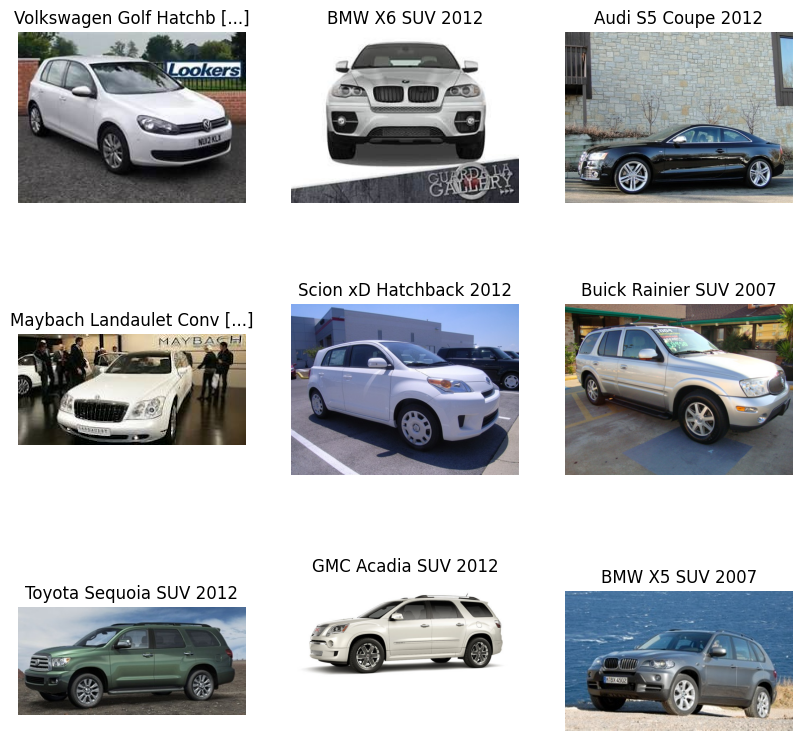

In [6]:
plt.figure(figsize=(10, 10))
classes_directory = random.choices(os.listdir(os.path.join(DATA_PATH, 'train')), k=9)

for i, class_name in enumerate(classes_directory):
    sample_filename = random.choice(os.listdir(os.path.join(DATA_PATH, 'train', class_name)))
    image_path = os.path.join(DATA_PATH, 'train', class_name, sample_filename)
    image = Image.open(image_path)
    
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image)
    plt.title(truncate_string(class_name, 25))
    plt.axis("off")

### Bar Chart of the class weight in training dataset

In [7]:
car_count_dict = {}

for class_folder in os.listdir(os.path.join(DATA_PATH, 'train')):
    count = len(os.listdir(os.path.join(DATA_PATH, 'train', class_folder)))
    car_count_dict[class_folder] = count

for class_folder in os.listdir(os.path.join(DATA_PATH, 'test')):
    count = len(os.listdir(os.path.join(DATA_PATH, 'test', class_folder)))
    car_count_dict[class_folder] += count

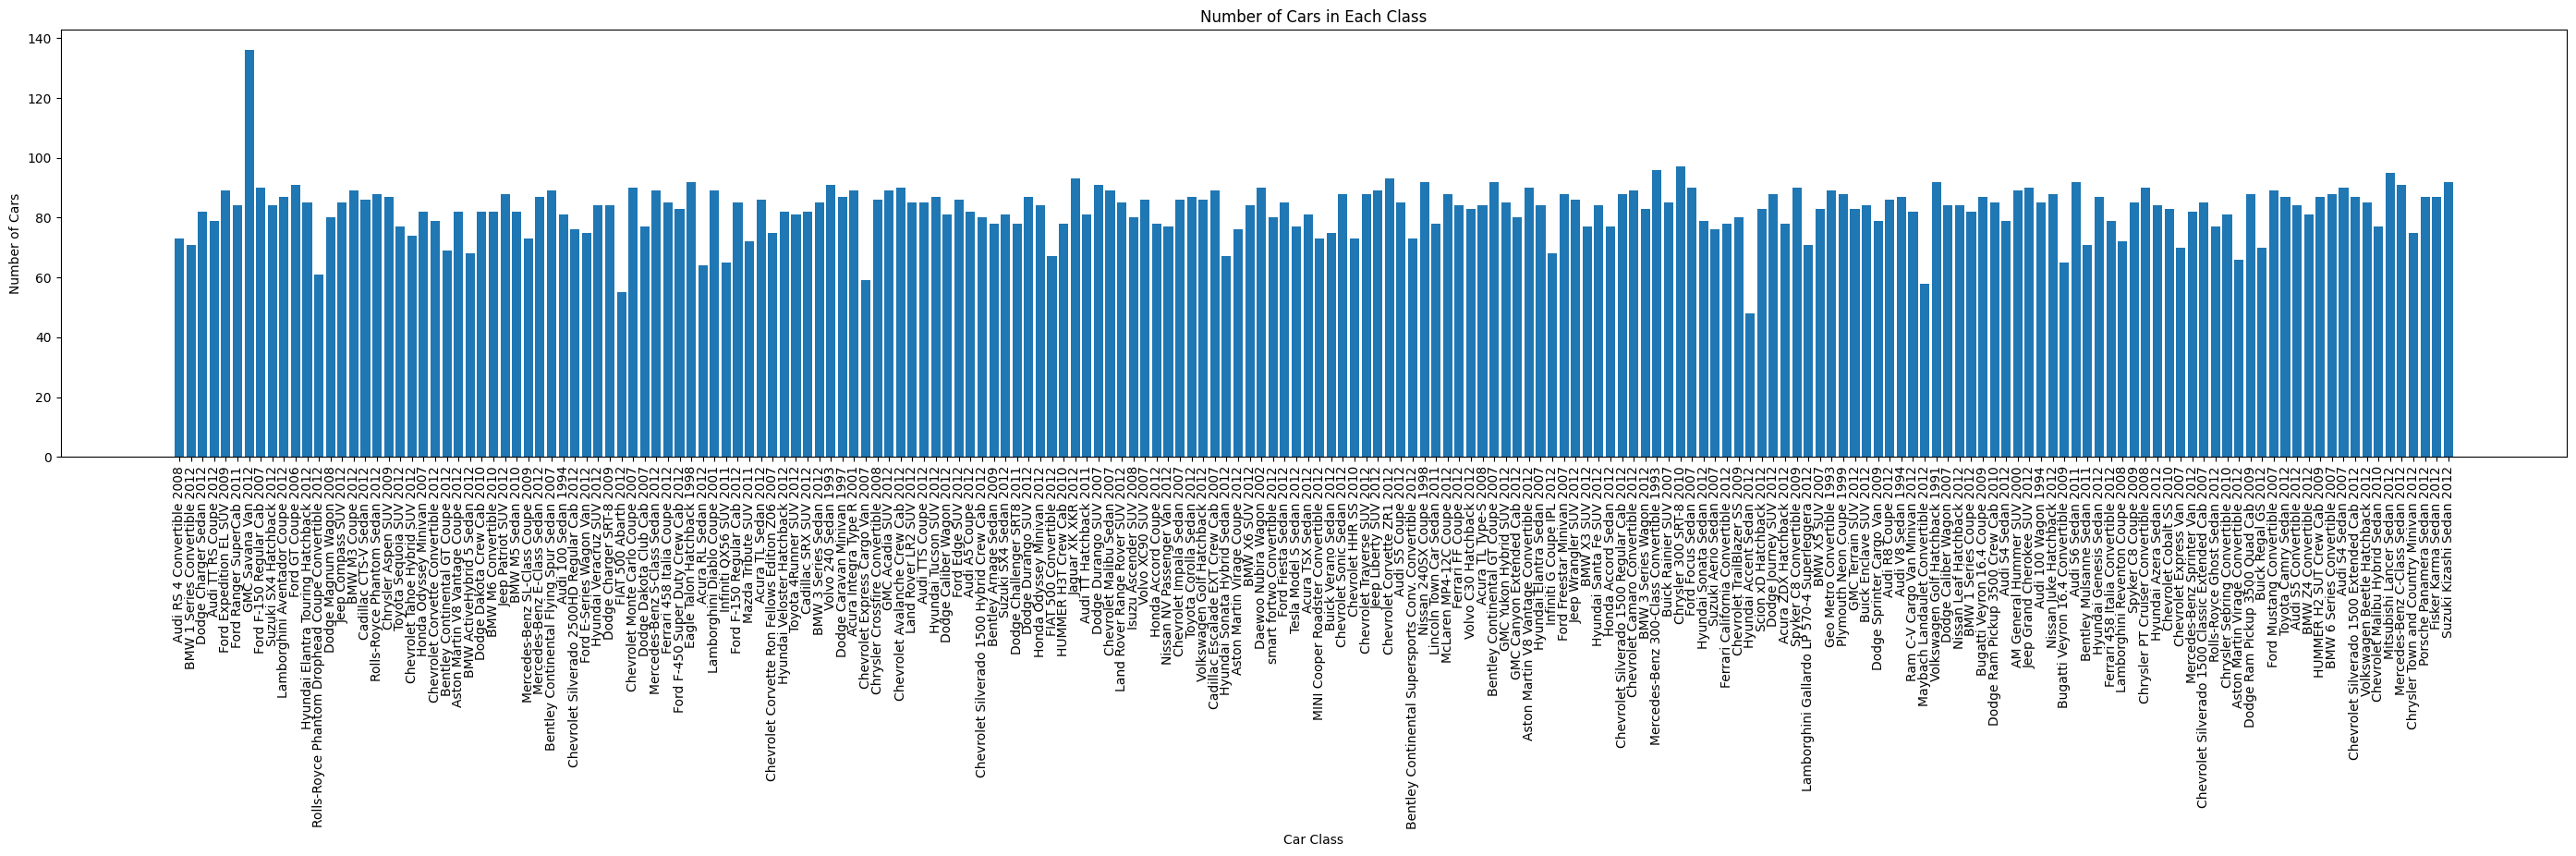

In [8]:
plt.figure(figsize=(35, 6))
plt.bar(car_count_dict.keys(), car_count_dict.values())

plt.xlabel('Car Class')
plt.ylabel('Number of Cars')
plt.title('Number of Cars in Each Class')

plt.xticks(rotation=90)
plt.show()

### Get the average size of images in the training Dataset

In [9]:
height, width = [], []
for class_folder in os.listdir(os.path.join(DATA_PATH, 'train')):
    for image_filename in os.listdir(os.path.join(DATA_PATH, 'train', class_folder)):
        image_path = os.path.join(DATA_PATH, 'train', class_folder, image_filename)
        image = Image.open(image_path)
        height.append(image.height)
        width.append(image.width)

mean_height = round(np.mean(np.array(height)))
mean_width = round(np.mean(np.array(width)))

print(f"{mean_width = }, {mean_height = }")

mean_width = 700, mean_height = 483


## Data augmentation

In [10]:
import multiprocessing

num_cores = multiprocessing.cpu_count()
print(f"{num_cores = }")

num_cores = 104


In [11]:
# Imported from ImageNet
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

In [12]:
# defining the transformation for the dataset
train_augmentation = transforms.Compose([transforms.Resize((224, 224)),
                                transforms.RandomHorizontalFlip(),
                                transforms.RandomRotation(15),
                                transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.2),
                                transforms.ToTensor(),
                                transforms.Normalize(mean, std)])

test_augmentation= transforms.Compose([transforms.Resize((224, 224)), #224
                                transforms.ToTensor(),
                                transforms.Normalize(mean, std)])

In [13]:
train_dataset = torchvision.datasets.ImageFolder(root=TRAIN_PATH, transform = train_augmentation)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size = 32, shuffle=True, num_workers = num_cores)

test_dataset = torchvision.datasets.ImageFolder(root=TEST_PATH, transform = test_augmentation)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size = 32, shuffle=False, num_workers = num_cores)

### Training the data

In [14]:
model = models.resnet18()

num_ftrs = model.fc.in_features
no_classes = len(train_dataset.classes)

# Adapt the last dense layer for the 200 avalaible classes
model.fc = nn.Linear(num_ftrs, no_classes)

### Display thee model architecture

In [15]:
model.parameters

<bound method Module.parameters of ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)


### Compute Class weights

In [16]:
# Transform string labels into int labels
counter = 0
label_to_int = {}

for class_name in os.listdir(os.path.join(DATA_PATH, 'train')):
    label_to_int[class_name] = counter
    counter += 1

sample_to_int = []
for class_folder in os.listdir(os.path.join(DATA_PATH, 'train')):
    for _ in os.listdir(os.path.join(DATA_PATH, 'train', class_folder)):
        sample_to_int.append(label_to_int[class_folder])

y = np.array(sample_to_int)

# Compute class weights
class_weights = compute_class_weight(class_weight="balanced", classes=np.unique(y), y=y)

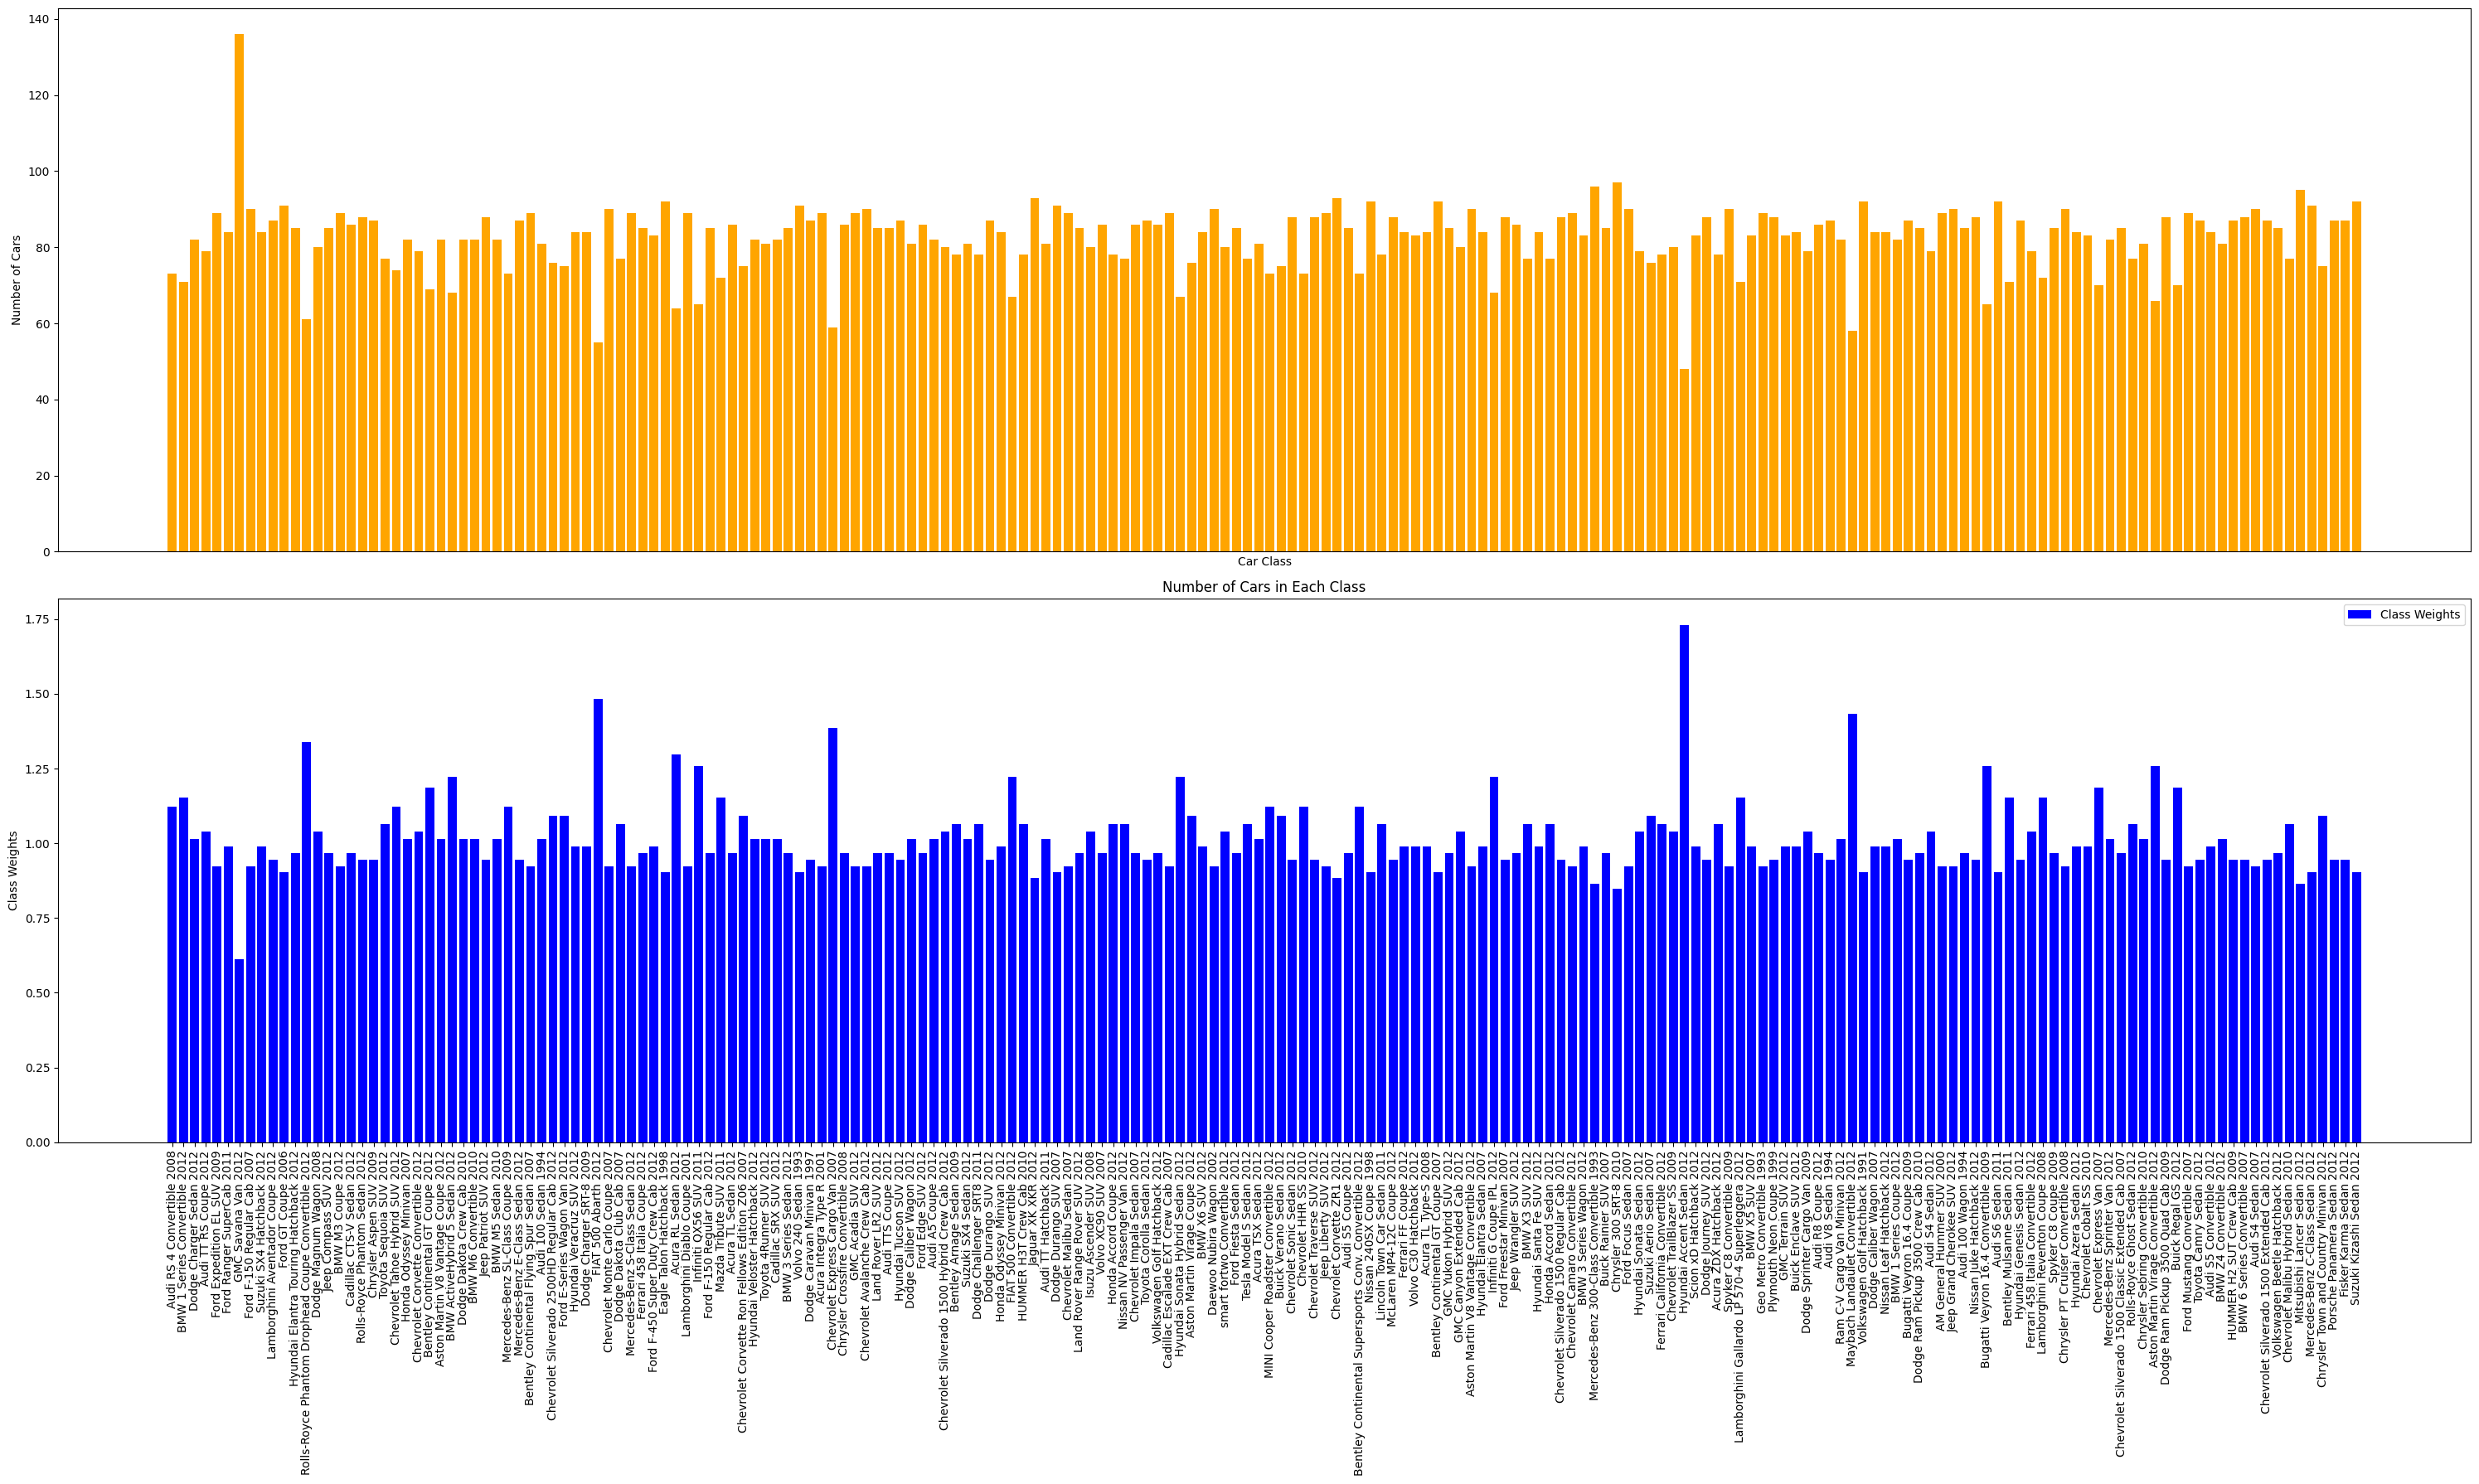

In [17]:
# Create a figure and two subplots side by side
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(30, 18))

# Plot the first bar graph on the first subplot (top)
ax1.bar(car_count_dict.keys(), car_count_dict.values(), color='orange', label='Car Count')
ax1.set_xlabel('Car Class')
ax1.set_ylabel('Number of Cars')
ax1.set_xticks([])

# Plot the second bar graph on the second subplot (bottom)
ax2.bar(car_count_dict.keys(), class_weights, color='blue', label='Class Weights')
ax2.set_ylabel('Class Weights')
ax2.set_title('Number of Cars in Each Class')
ax2.legend()

# Rotate x-axis labels for better visibility
plt.setp(ax2.get_xticklabels(), rotation=90)

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()

In [18]:
model = model.to(device)

# defining the loss function and the optimizer
criterion = nn.CrossEntropyLoss(weight=torch.from_numpy(class_weights), label_smoothing=0.02)
optimizer = optim.Adam(model.parameters(), weight_decay=1e-5) # weight_decay == L2 (riddge)

In [19]:
lrscheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=3, threshold = 0.1)

In [23]:
def eval_model(model, test_loader, device, test_time_tsfm=None, num_augmentations=1):
    correct = 0.0
    total = 0.0
    with torch.no_grad():
        # Iterate over the test data and generate predictions.
        for i, data in enumerate(test_loader, 0):
            # Get inputs
            images, labels = data
            # Transfer to GPU
            images = images.to(device)
            labels = labels.to(device)
            # If test time augmentation is provided, apply transformations
            if test_time_tsfm is not None:
                augmented_images = []
                for img in images:
                    augmented_images.extend(img)
                    # Apply the transformation num_augmentations times
                    augmented_imgs = [test_time_tsfm(img) for _ in range(num_augmentations)]
                    # Stack the augmented images into a single tensor and add to the list
                    augmented_images.extend(augmented_imgs)
                # Convert the list of augmented images to a single tensor
                images = torch.stack(augmented_images)

            # Forward pass
            outputs = model(images)
            # Get predictions from the maximum value 
            _, predicted = torch.max(outputs.data, 1)
            # Total number of labels in the test data set
            total += labels.size(0) * num_augmentations
            # Total correct predictions
            correct += (predicted == labels.repeat(num_augmentations)).sum().item()
    # Calculate the accuracy
    test_acc = 100.0 * correct / total
    print('Accuracy of the network on the test images: %d %%' % (
        test_acc))
    return test_acc

In [24]:
def train_model(model, train_loader, test_loader, criterion, optimizer, scheduler, device, n_epochs = 5):
    # keeping track of losses and the accuracies
    losses = []
    accuracies = []
    test_accuracies = []
    # set the model to train mode initially (This is important as some models behave differently in train and test time.)
    model.train()
    # loop over the epochs
    for epoch in tqdm(range(n_epochs)):
        # keep track of the time for training the model for each epoch
        since = time.time()
        running_loss = 0.0
        running_correct = 0.0
        # iterate over the training data
        for i, data in enumerate(train_loader, 0):
            # get the inputs and assign them to cuda
            inputs, labels = data
            # Transfer to GPU
            inputs = inputs.to(device)
            labels = labels.to(device)
            # zero the parameter gradients
            optimizer.zero_grad()
            # forward pass
            outputs = model(inputs)
            # get the predictions
            _, predicted = torch.max(outputs.data, 1)
            # calculate the loss
            loss = criterion(outputs, labels)
            # backward pass
            loss.backward()
            # optimize the weights
            optimizer.step()
            # calculate the loss
            running_loss += loss.item()
            # calculate the accuracy
            running_correct += (labels==predicted).sum().item()
        # calculate the duration for each epoch
        epoch_duration = time.time()-since
        epoch_loss = running_loss/len(train_loader)
        epoch_acc = 100/32*running_correct/len(train_loader)
        print("Epoch %s, duration: %d s, loss: %.4f, acc: %.4f" % (epoch+1, epoch_duration, epoch_loss, epoch_acc))
        # append the losses and the accuracies
        losses.append(epoch_loss)
        accuracies.append(epoch_acc)
        # switch the model to eval mode to evaluate on test data
        model.eval()
        test_acc = eval_model(model, test_loader, device)
        test_accuracies.append(test_acc)
        # re-set the model to train mode after validating
        model.train()
        scheduler.step(test_acc)
        since = time.time()
    print('Finished Training')
    return model, losses, accuracies, test_accuracies

In [25]:
n_epochs = 30
# train the model
model, training_losses, training_accs, test_accs = train_model(model, train_loader, 
                            test_loader, criterion, optimizer, lrscheduler, device, n_epochs=n_epochs)

  0%|          | 0/30 [00:08<?, ?it/s]


RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cuda:0 and cpu! (when checking argument for argument weight in method wrapper_CUDA_nll_loss_forward)

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

# Plot training loss
axs[0].plot(training_losses)
axs[0].set_title("Training Loss")

# Plot training and test accuracy
axs[1].plot(training_accs, label="Training Accuracy")
axs[1].plot(test_accs, label="Test Accuracy")
axs[1].set_title("Training and Test Accuracy")
axs[1].legend()

plt.tight_layout()
plt.show()